# Image classification using Perceptron

* Since a single perceptron could only be used for binary clssification,we consider only two classes in the first half.Eventually we will extend it to multi-class setting.
* Suppose we want to recognize whether the given image is of digit zero or not. Then the problem could be cast as binary classification.
* First: create a dataset contains the image of digit iamges written by humans.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import io
import warnings

#sklearn imports
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import Perceptron
from sklearn.metrics import hinge_loss, ConfusionMatrixDisplay, confusion_matrix, precision_recall_curve, precision_score,recall_score,classification_report, make_scorer
from sklearn.model_selection import cross_validate, cross_val_predict, GridSearchCV
from pprint import pprint


## Data loading and Spliting

In [9]:
X,y= fetch_openml('mnist_784', version=1, return_X_y=True)
#it returns Data and label as pandas dataframe

The data matrix X and the respective label vector y need to be converted to the numpy array by calling a to_numpy method.

In [10]:
X=X.to_numpy()
y=y.to_numpy()

In [20]:
target_names=np.unique(y)
print('Number of samples:{0},type:{1}'.format(X.shape[0],X.dtype))
print('Number of features:{0}'.format(X.shape[1]))
print('Minimum:{0}, Maximum:{1}'.format(np.min(X),np.max(X)))
print('Number of classes:{0},type:{1}'.format(len(target_names),y.dtype))
print('Labels:{0}'.format(target_names))

Number of samples:70000,type:float64
Number of features:784
Minimum:0.0, Maximum:255.0
Number of classes:10,type:object
Labels:['0' '1' '2' '3' '4' '5' '6' '7' '8' '9']


* So, by looking at the outcome we can conclude that the each image comes with 784 features and there are such 70000 samples.
* Each feature define a pixel in the grid
* pixel range [0,255]
* Each image comes in 28X28 grid which makes 784


Standardizing the feature using MinMaxScaler preprocessing

In [25]:
X=MinMaxScaler().fit_transform(X)
print("Minimum:{0},Maximum{1}".format(np.min(X),np.max(X)))

Minimum:0.0,Maximum1.0


## Data visualization

Image are stacked as a row vector 1 X 784 and therefore must be reshaped to the matrix of size 28 x 28 to display them properly.

C:\Users\Deepak sirohiwal\AppData\Local\Temp\ipykernel_9204\1473982052.py:2: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  factor = np.int(np.sqrt(num_images))


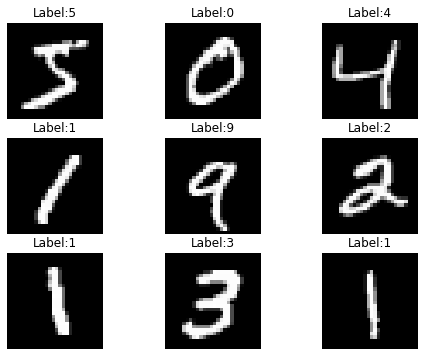

In [29]:
num_images= 9 # Choose a square number
factor = np.int(np.sqrt(num_images))
fig,ax=plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset=0
for i in range(factor):
    index=idx_offset+i*(factor)
    for j in range(factor):
        ax[i,j].imshow(X[index+j].reshape(28,28),cmap='gray')
        ax[i,j].set_title('Label:{0}'.format(str(y[index+j])))
        ax[i,j].set_axis_off()

## Data spliting

* Spliting data into testing and training data 
* 60,000 samples for training and 10,000 for testing
* Since the sample in the data set are already shuffled, we need not be shuffle it again. Therefore using train_test_split() may be skipped

In [30]:
x_train,x_test,y_train,y_test= X[:60000],X[60000:],y[:60000],y[60000:]

Checking if the dataset are balanced

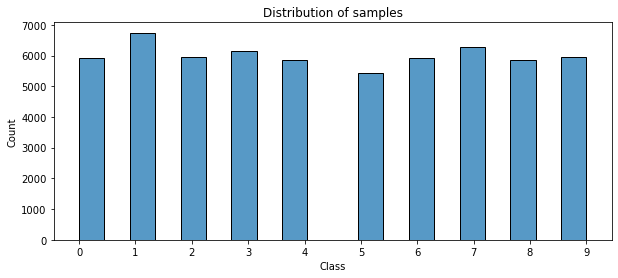

In [33]:
plt.figure(figsize=(10,4))
sns.histplot(data=np.int8(y_train),binwidth=0.45,bins=11)
plt.xticks(ticks=[0,1,2,3,4,5,6,7,8,9],labels=[0,1,2,3,4,5,6,7,8,9])
plt.xlabel('Class')
plt.title('Distribution of samples')
plt.show()

## Binary Classification: 0-Detector

### Modifying Labels
* 0 will be changed to 1 and all other labels(1-9) will be changed to -1

In [40]:
#initialize new variable name with all -1
y_train_0=-1*np.ones((len(y_train)))
y_test_0=-1*np.ones((len(y_test)))

#find indices of digit 0 image
indx_0= np.where(y_train=='0') #coz original data is of string type

y_train_0[indx_0]=1

indx_0=np.where(y_test=='0')
y_test_0[indx_0]=1

### Baseline models

1. Count number of samples per class.
2. The model always outputs the class which has highest number of samples.
3. Then calculate the accuracy of the baseline model.

In [45]:
num_pos=len(np.where(y_train_0==1)[0])
num_neg= len(np.where(y_train_0==-1)[0])

print(num_pos,num_neg)

5923 54077


In [46]:
base_clf= DummyClassifier(strategy='most_frequent')


In [47]:
base_clf.fit(x_train,y_train_0)
print("Training accuracy:{0:.2f}".format(base_clf.score(x_train,y_train_0)))
print("Training accuracy:{0:.2f}".format(base_clf.score(x_test,y_test_0)))


Training accuracy:0.90
Training accuracy:0.90


The model would have predicted 54077 sample correctly just by outputing -1 for all the input samples. Therefore the accuracy will be 54077/60000=90.12%

### Perceptron model

In [48]:
bin_clf=Perceptron(max_iter=100,random_state=1729)

Training and prediction

In [49]:
bin_clf.fit(x_train,y_train_0)
print('Dimention of weight w: {0}'.format(bin_clf.coef_.shape))
print('Bias:{0}'.format(bin_clf.intercept_))
print('The loss function: {0}'.format(bin_clf.loss_function_))

Dimention of weight w: (1, 784)
Bias:[-108.]
The loss function: <sklearn.linear_model._sgd_fast.Hinge object at 0x000001D6C8D067D0>


In [51]:
y_hat_train_0=bin_clf.predict(x_train)
print('Training accuracy:',bin_clf.score(x_train,y_train_0))
print('Test accuracy', bin_clf.score(x_test,y_test_0))

Training accuracy: 0.99095
Test accuracy 0.989


### Displaying predictions

C:\Users\Deepak sirohiwal\AppData\Local\Temp\ipykernel_9204\2193411666.py:3: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  factor = np.int(np.sqrt(num_images))


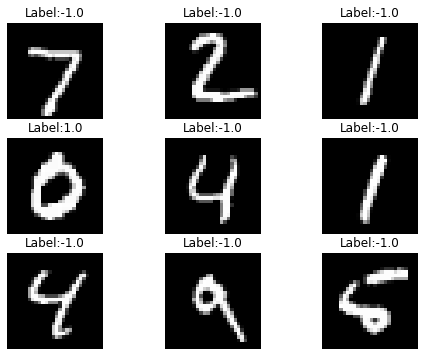

In [52]:
y_hat_test_0=bin_clf.predict(x_test)
num_images= 9 # Choose a square number
factor = np.int(np.sqrt(num_images))
fig,ax=plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset=0
for i in range(factor):
    index=idx_offset+i*(factor)
    for j in range(factor):
        ax[i,j].imshow(x_test[index+j].reshape(28,28),cmap='gray')
        ax[i,j].set_title('Label:{0}'.format(str(y_hat_test_0[index+j])))
        ax[i,j].set_axis_off()

Display image of positive class

In [53]:
index_0=np.where(y_test_0==1)


C:\Users\Deepak sirohiwal\AppData\Local\Temp\ipykernel_9204\3669091268.py:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  factor = np.int(np.sqrt(num_images))


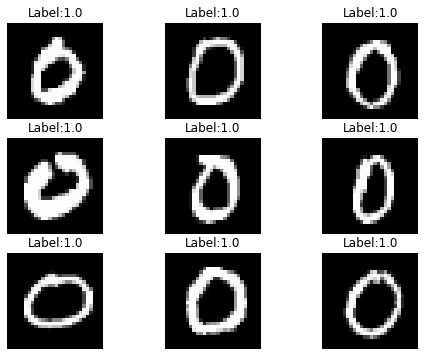

In [54]:
zeroImgs=x_test[index_0[0]]
zeroLabels=y_hat_test_0[index_0[0]]

num_images= 9 # Choose a square number
factor = np.int(np.sqrt(num_images))
fig,ax=plt.subplots(nrows=factor,ncols=factor,figsize=(8,6))
idx_offset=0
for i in range(factor):
    index=idx_offset+i*(factor)
    for j in range(factor):
        ax[i,j].imshow(zeroImgs[index+j].reshape(28,28),cmap='gray')
        ax[i,j].set_title('Label:{0}'.format(str(zeroLabels[index+j])))
        ax[i,j].set_axis_off()

In [15]:
import numpy as np
from sklearn.model_selection import RepeatedKFold
X=np.array([[1,2],[3,4],[1,2],[3,4]])
rkf=RepeatedKFold(n_splits=2,
n_repeats=2,
random_state=1)

In [16]:
for train,test in rkf.split(X):
    print("%s %s"%(train,test))

[0 1] [2 3]
[2 3] [0 1]
[1 3] [0 2]
[0 2] [1 3]


In [17]:
import numpy as np
from sklearn.preprocessing import FunctionTransformer
transformer = FunctionTransformer(np.log1p)
X = np.array([[0, 9], [7, 8]])
transformer.transform(X)

array([[0.        , 2.30258509],
       [2.07944154, 2.19722458]])

In [23]:
print(np.log1p(9))
print(np.log(10))

2.302585092994046
2.302585092994046
